In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.shape

(50000, 2)

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [5]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

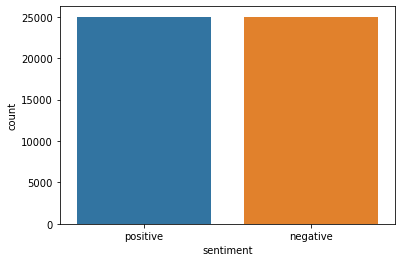

In [8]:
sns.countplot(x="sentiment", data=df)

<AxesSubplot:ylabel='sentiment'>

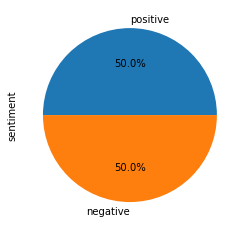

In [9]:
df['sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%')

### Text preprocessing

In [11]:
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    text = re.sub(r'\W', ' ', text) # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
    return text
df['review'] = df['review'].apply(clean_text)

### Tokenization

In [14]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Found 101702 unique tokens.
Shape of data tensor: (50000, 250)


### Data Preparation

In [16]:
Y = pd.get_dummies(df['sentiment']).values
print('Shape of label tensor:', Y.shape)

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of label tensor: (50000, 2)
(40000, 250) (40000, 2)
(10000, 250) (10000, 2)


### Modeling

In [17]:
# Define LSTM model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train the model
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
563/563 [==============================] - 804s 1s/step - loss: 0.3325 - accuracy: 0.8541 - val_l

In [18]:
# Validate the model
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

313/313 [==============================] - 40s 126ms/step - loss: 0.4235 - accuracy: 0.8793
Test set
  Loss: 0.423
  Accuracy: 0.879
